# ```TB_to_sympy```: Simplifying Hamiltonian Expressions for Condensed Matter Systems Within a Tight-Binding Model Framework.

## Introduction. ##

The tight-binding (TB) model is used in condensed matter physics to model the properties of conductors, semiconductors, and insulators. Experimental physicists often interact with the TB model during electronic band structure measurements, like angle-resolved photoemission spectroscopy (ARPES). They must verify that their experimental data aligns with theoretical predictions. The TB model's tractability offers a clear analytical solution, which proves efficient for experimentalists to quickly validate their data. Thus, there's a need for a function like ```TB_to_sympy```, which provides a reduced analytical Hamiltonian expression for the analyzed element.

If you model electrons as tightly bound to atoms, you get the TB model which assumes that main electronic behavior arises from interactions between neighboring atoms, where electrons hop between atomic orbitals through tunneling or wavefunction overlap.
The TB model is a minimal model that serves as a foundation for studying electron behavior in metals, including the origins of magnetism and superconductivity:
- For theorists, it reduces the number of parameters, from which they can study the effects of the parameters separately.
- For experimentalists, it’s useful for a one-body description of the electronic structure. Therefore, if they can understand their data by using a simple representation like a TB model, their data can be understood simply. An analytical TB model with a restricted number of parameters can help experimentalists fit their data.

The ```TB_to_sympy``` function takes hopping amplitudes to generate a TB model. The hopping amplitudes are obtained from the Wannier90 package, which fits the band structure obtained from density functional theory (DFT) for a set of orbitals. The larger the hopping amplitude, the more significant it is. For instance, a hopping amplitude of 0.00005 eV does not contribute as much to the movement of an electron as a hopping amplitude of 0.05 eV. There is a need for a cutoff either in the hopping distances or the hopping amplitudes. A minimal model can neglect these smaller amplitudes. Using the PythTB package's ```model``` function, we select only the hopping amplitudes bigger than the cutoff or smaller than the cutoff distance, restricting the hopping processes to be closer.

In second quantization, the TB Hamiltonian is given by:

$$
H = -\sum_{i j l_1 l_2 \sigma} t_{i j}^{l_1 l_2} [c^{\dagger}_{i l_1 \sigma} c_{j l_2 \sigma} + c^{\dagger}_{j l_2 \sigma} c_{i l_1 \sigma}]
$$

where:
- $t_{i j}^{l_1 l_2}$ is the hopping amplitude between orbital $l_1$ on site $i$ and orbital $l_2$ on site $j$.
- $\sigma$ is the spin and $c^{\dagger}$
- $c$ are creation and annihilation operators.

In this tutorial, we examine a system with one orbital and one site per unit cell. By performing a Fourier transform of the Hamiltonian from real space to momentum space, we obtain $H(k)$, which is achieved using the ```TB_to_sympy``` function.

$$
H(k) = \frac{1}{(2\pi)^d} \sum_{R} e^{i k \cdot R} H_{R}
$$

### Function Definition and its Parameters. ###

```TB_to_sympy``` is defined as:
```python
def TB_to_sympy(w90_triqs, analytical = True, precision = 6):

The only required parameter for our function is ```w90_triqs```, a TRIQS TBLattice Object (Tight-Binding Lattice Object). To obtain ```w90_triqs```, you can use TRIQS-provided functions that allow conversion of your model to a TRIQS TBLattice object. These functions are:
1. ```TB_from_pythTB``` that converts your model from a pythTB model to a TRIQS TBLattice Object.
2. ```TB_from_wannier90``` which converts your model from a Wannier90 model to a TRIQS TBLattice Object. It reads wannier90 output and converts it to a TBLattice object.

Currently, it is advisable to utilize ```TB_from_pythTB``` since it enables straightforward initiation of cutoffs to your pythTB model before converting it to a TBLattice object, especially for complex systems, granting greater control over your model and allows examination of the output's behavior at different cutoffs. The possible cutoff parameters in pythTB include:
1. ```zero_energy```: This parameter establishes the energy zero point in the band structure, typically aligned with the Fermi level.
2. ```min_hopping_norm```: The hopping terms obtained from Wannier90 are filtered based on their hopping amplitudes (measured in electron volts). Terms with amplitudes less than ```min_hopping_norm``` are excluded from the calculations.
3. ```max_distance```: Hopping distances exceeding ```max_distance``` are disregarded during the calculations.

The ```analytical``` flag ensures that the default Hamiltonian returned by ```sympyfy``` is in an analytical form. If the user sets the ```analytical``` flag to ```False```, the resulting Hamiltonian will be in a "numerical" form. Although termed "numerical," this expression still depends on the parameters of the k-space vectors (```kx```, ```ky```, and ```kz```) as the lattice constants and vectors are expressed numerically. For simplicity, we will continue to refer to it as numerical in this tutorial, assuming the user can provide numerical values for ```kx```, ```ky```, and ```kz```.

Lastly, the ```precision``` parameter allows the user to control the number of digits in the hopping amplitudes and lattice parameters.

## Calling the Function ##

Let us first import the necessary dependencies.

In [4]:
# importing the dependencies
from itertools import product as itp
from pythtb import *
from triqs.lattice.tight_binding import TBLattice
import sympy as sp
import warnings
import numpy as np
import matplotlib.pyplot as plt

# importing the file containing the TB_to_sympy function
import TB_to_sympy
from TB_to_sympy import TB_to_sympy

Let us first load a model of $La_2CuO_4$, lanthanum copper oxide, a high-temperature superconductor:

In [5]:
from triqs.lattice.utils import TB_from_pythTB
# accessing the necessary Wannier90 output files
w90_input = w90('AbinitioDMFT/data/mlwf/', 'lco')
fermi_ev = 12.7367
w90_model = w90_input.model(zero_energy = fermi_ev, min_hopping_norm = 0.05, max_distance = None)
w90_triqs_La2CuO4 = TB_from_pythTB(w90_model)

We can call ```TB_from_sympy``` for different cases depending on the values we assign to its parameters. Here is one case:

In [6]:
print("The analytical expression \n", TB_to_sympy(w90_triqs_La2CuO4, analytical = True, precision = 3))

The analytical expression 
 [[-0.88*cos(a1k + a3k) - 0.88*cos(a2k + a3k) + 0.159]]


In [7]:
print("The numerical expression \n", TB_to_sympy(w90_triqs_La2CuO4, analytical = False, precision = 3))

The numerical expression 
 [[-0.88*cos(3.818*kx) - 0.88*cos(3.818*ky) + 0.159]]


The main distinction between the analytical and numerical expressions is that the numerical expression depends on ```kx```, ```ky```, and ```kz```, while the analytical expression additionally depends on the lattice vectors, ```a1```, ```a2```, and ```a3```. The lattice vectors define the orientation and shape of the crystal unit cell and can be replaced with numerical values using the ```units``` function from the TRIQS TB lattice object.

## Comparing Minimal Models ##

Let's create a figure to compare three minimal models, each with different `min_hopping_norm` cutoffs, against the full model from Wannier90. In the snippet below we compare 3 minimal models. You are free to choose the cutoffs you wish.

First, let us create a function that deals with making the minimal models:

In [8]:
def minimal_model(w90_input, fermi_ev, cutoff):
    # get band structure from Wannier90 in the form of
    # list of k-points in reduced coordinates
    # energies interpolated by Wannier90
    (w90_kpt, w90_evals) = w90_input.w90_bands_consistency()

    # obtain simplified model based on various cutoffs
    w90_model = w90_input.model(zero_energy = fermi_ev, min_hopping_norm = cutoff, max_distance = None)

    # solve simplified model on the same k-path as in Wannier90
    return w90_model.solve_all(w90_kpt)

Next, let us set up the plot:

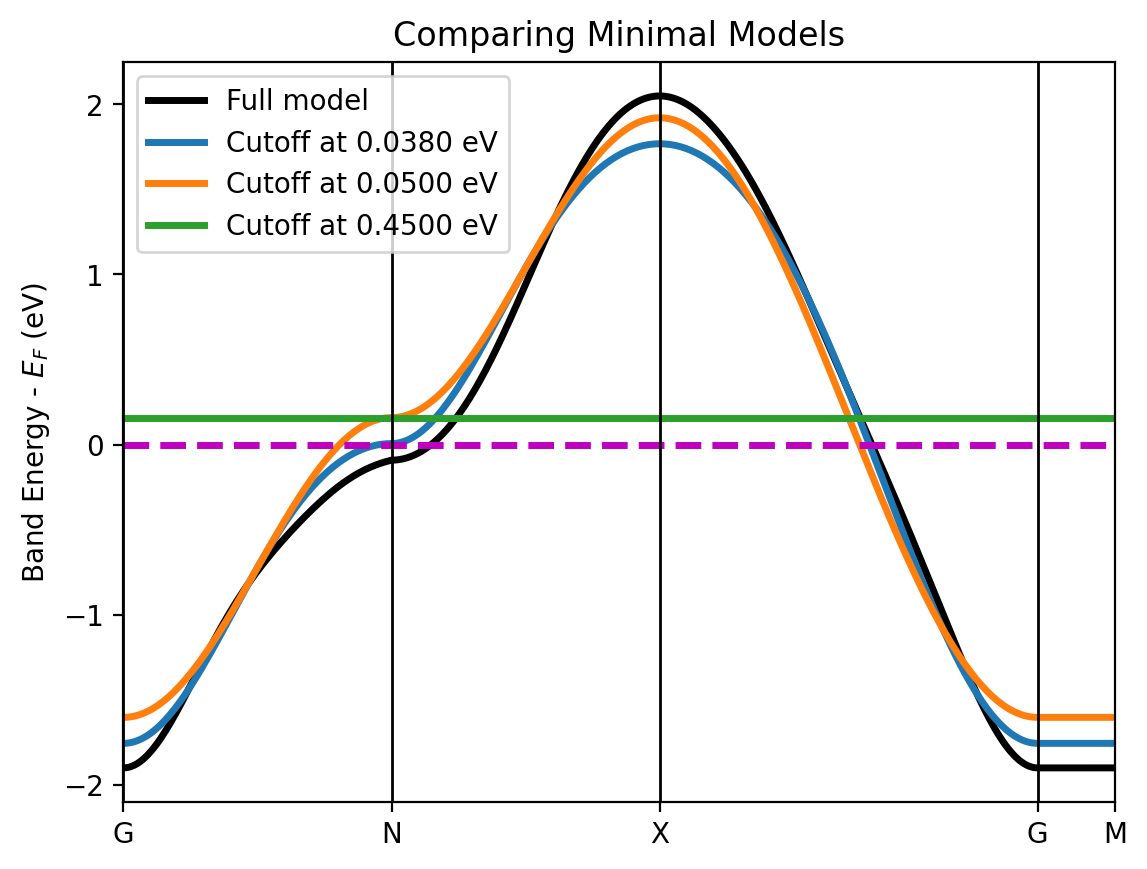

In [9]:
# setting up the plots
fig, ax = plt.subplots(dpi = 200)

# plotting the full Wannier90 model
(w90_kpt, w90_evals) = w90_input.w90_bands_consistency()
for i in range(w90_evals.shape[0]):
    x_axis = list(range(w90_evals.shape[1]))
    y_axis = w90_evals[i] - fermi_ev
    ax.plot(x_axis, y_axis, "k-", zorder = -100, label = "Full model")

# plotting the minimal models
for cutoff in [0.038, 0.05, 0.45]:
    int_evals = minimal_model(w90_input, fermi_ev, cutoff)
    for i in range(int_evals.shape[0]):
        ax.plot(list(range(int_evals.shape[1])), int_evals[i], zorder = -50, label = "Cutoff at %.4f eV" % cutoff)
    
# plotting the horizontal line that passes through the y-axis
ax.axhline(y = 0, color = 'm', linestyle = '--')
ax.set_yticks(np.arange(-2, 2.1, step = 1))

# increasing the width of the curves
lines = ax.lines
for line in lines:
    line.set_linewidth(2.5)

# coordinates of the high symmetry points
G = np.array([0.00, 0.00, 0.00])
N = np.array([0.25, -0.25, 0.25])
X = np.array([0.00, 0.00, 0.50])
M = np.array([0.25, 0.25, -0.25])

# x-axis labels of the high-symmetry points
kpath_labels = ['G', 'N', 'X', 'G', 'M']
idx_kpt = {}

# checking k-point coordinates equal to the high-symmetry point coordinates
for name, idx in (zip(('G', 'N', 'X', 'M'), [G, N, X, M])):
    idx_kpt[name] = list(np.where((w90_kpt == idx).all(axis = 1))[0])
    
# setting the x-axis ticks
kpath_xticks = list([x[0] for x in idx_kpt.values()])
kpath_xticks.append(idx_kpt['G'][1])
kpath_xticks = sorted(kpath_xticks)
ax.set_xticks(kpath_xticks)
ax.set_xticklabels(kpath_labels)

# setting the vertical lines at the high-symmetry points
for n in range(len(kpath_xticks)):
    ax.axvline(x = kpath_xticks[n], linewidth = 1, color = 'k')

# plot properties
ax.set_xlim(0, int_evals.shape[1] - 1)
ax.set_ylabel(r"Band Energy - $E_F$ (eV)")
ax.set_title("Comparing Minimal Models")
ax.legend()

The band structure's accuracy depends on the user's choice of ```min_hopping_norm``` and ```max_distance``` values. By adjusting these parameters, the cutoff model can closely resemble the full Wannier90 model while providing a concise analytical Hamiltonian expression. Below is a visual example illustrating this.

With a lower cutoff more hopping amplitudes are included which makes for a band structure that closely resembles the full Wannier90 band structure (which has all the hopping amplitudes present, that is, the full Wannier90 model includes all the hopping amplitudes when calculating the band energies across multiple k-paths).